# Nano-Classification with LSTM

In [5]:
import numpy as np
from pandas import read_json, concat, get_dummies, DataFrame
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk import FreqDist
import string
import seaborn as sn

## Data

In [6]:
abstracts = read_json("../Data/Datasets/abstracts.json")
abstracts = preprocess(abstracts)
abstracts.head(5)

NameError: name 'preprocess' is not defined

### Nano vs Non-Nano Distribution

Number of Documents: 993
Number of Nano Abstracts: 493
Number of Non-Nano Abstracts: 500


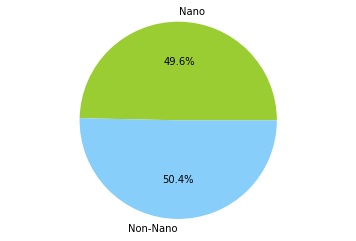

In [7]:
nano = abstracts[abstracts['is_nano'] == "Yes"]
non_nano = abstracts[abstracts['is_nano'] == "No"]
print("Number of Documents:", abstracts.shape[0])
print("Number of Nano Abstracts:", nano.shape[0])
print("Number of Non-Nano Abstracts:", non_nano.shape[0])
sizes = [nano.shape[0], non_nano.shape[0]]
labels=["Nano", "Non-Nano"]
colors = ['yellowgreen','lightskyblue']

plt.pie(sizes, labels=labels, colors=colors,  autopct='%1.1f%%')
plt.axis('equal')
plt.show()

### What Journal's are most prevalent in each dataset?

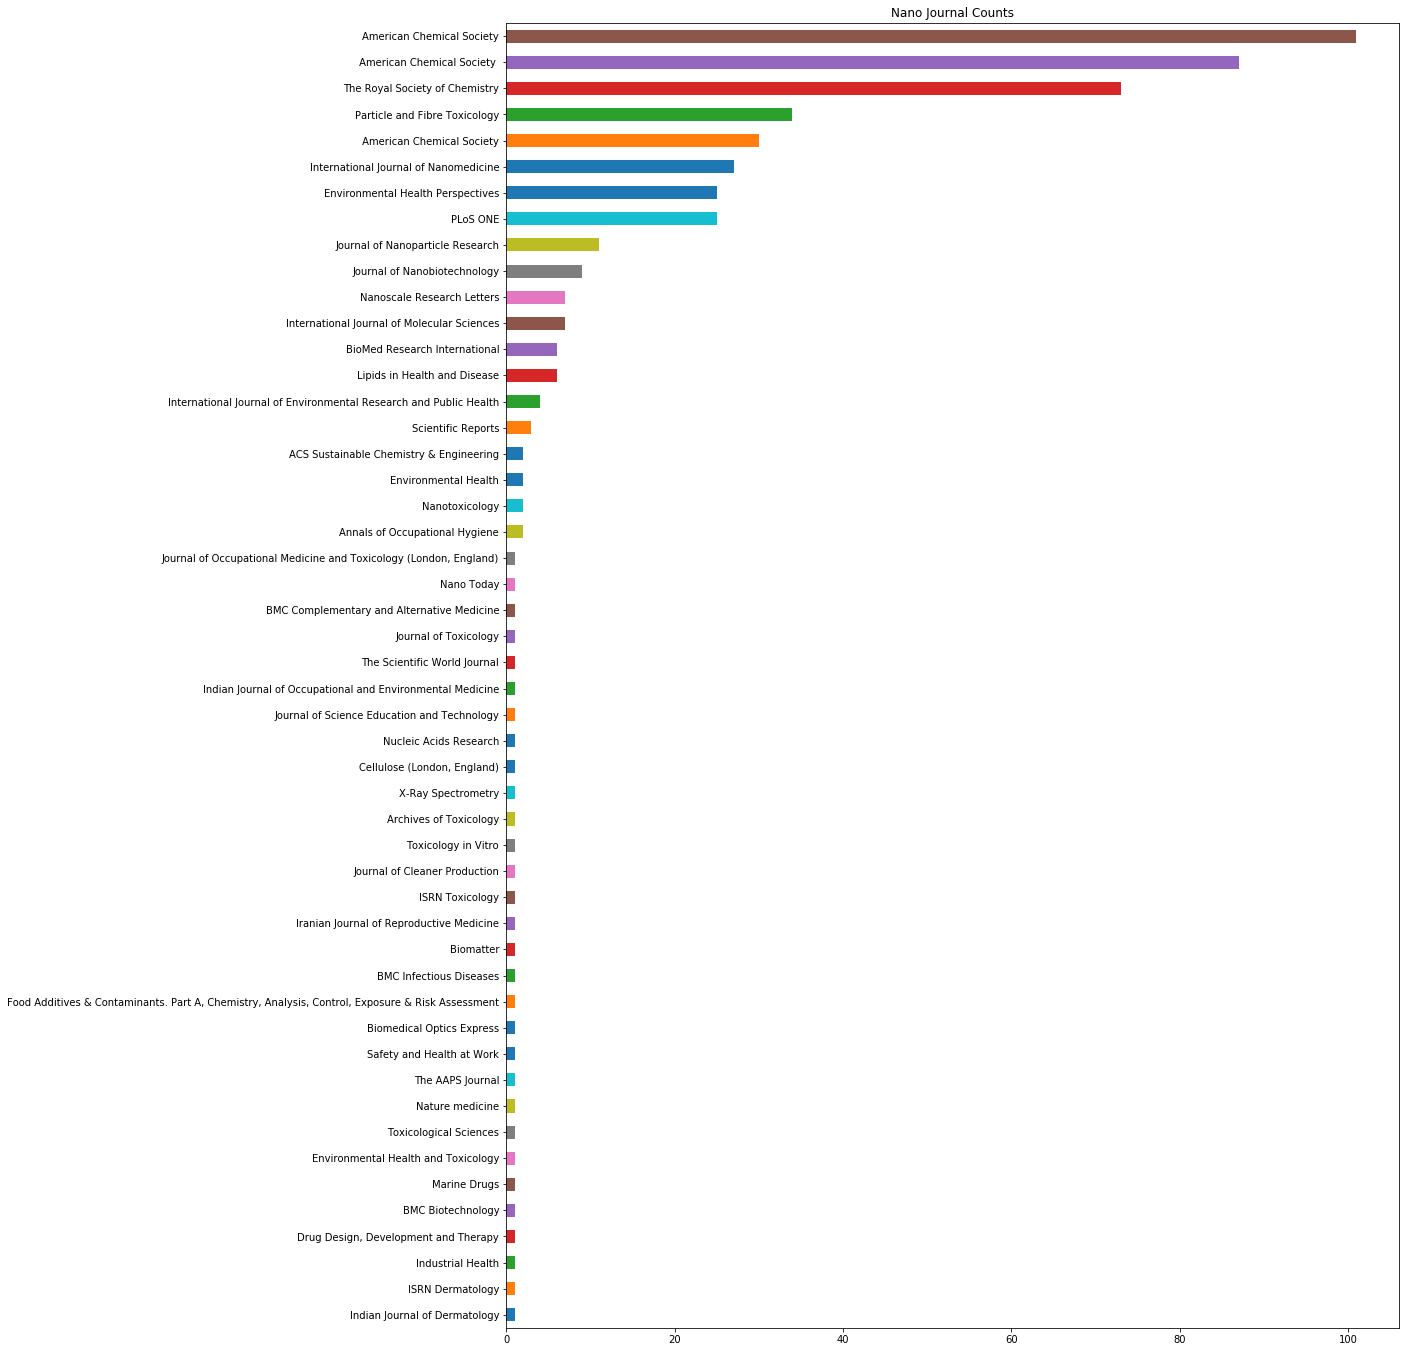

In [8]:
nano['journal'].value_counts(ascending=True).plot(kind="barh", figsize=(16,24), title="Nano Journal Counts")

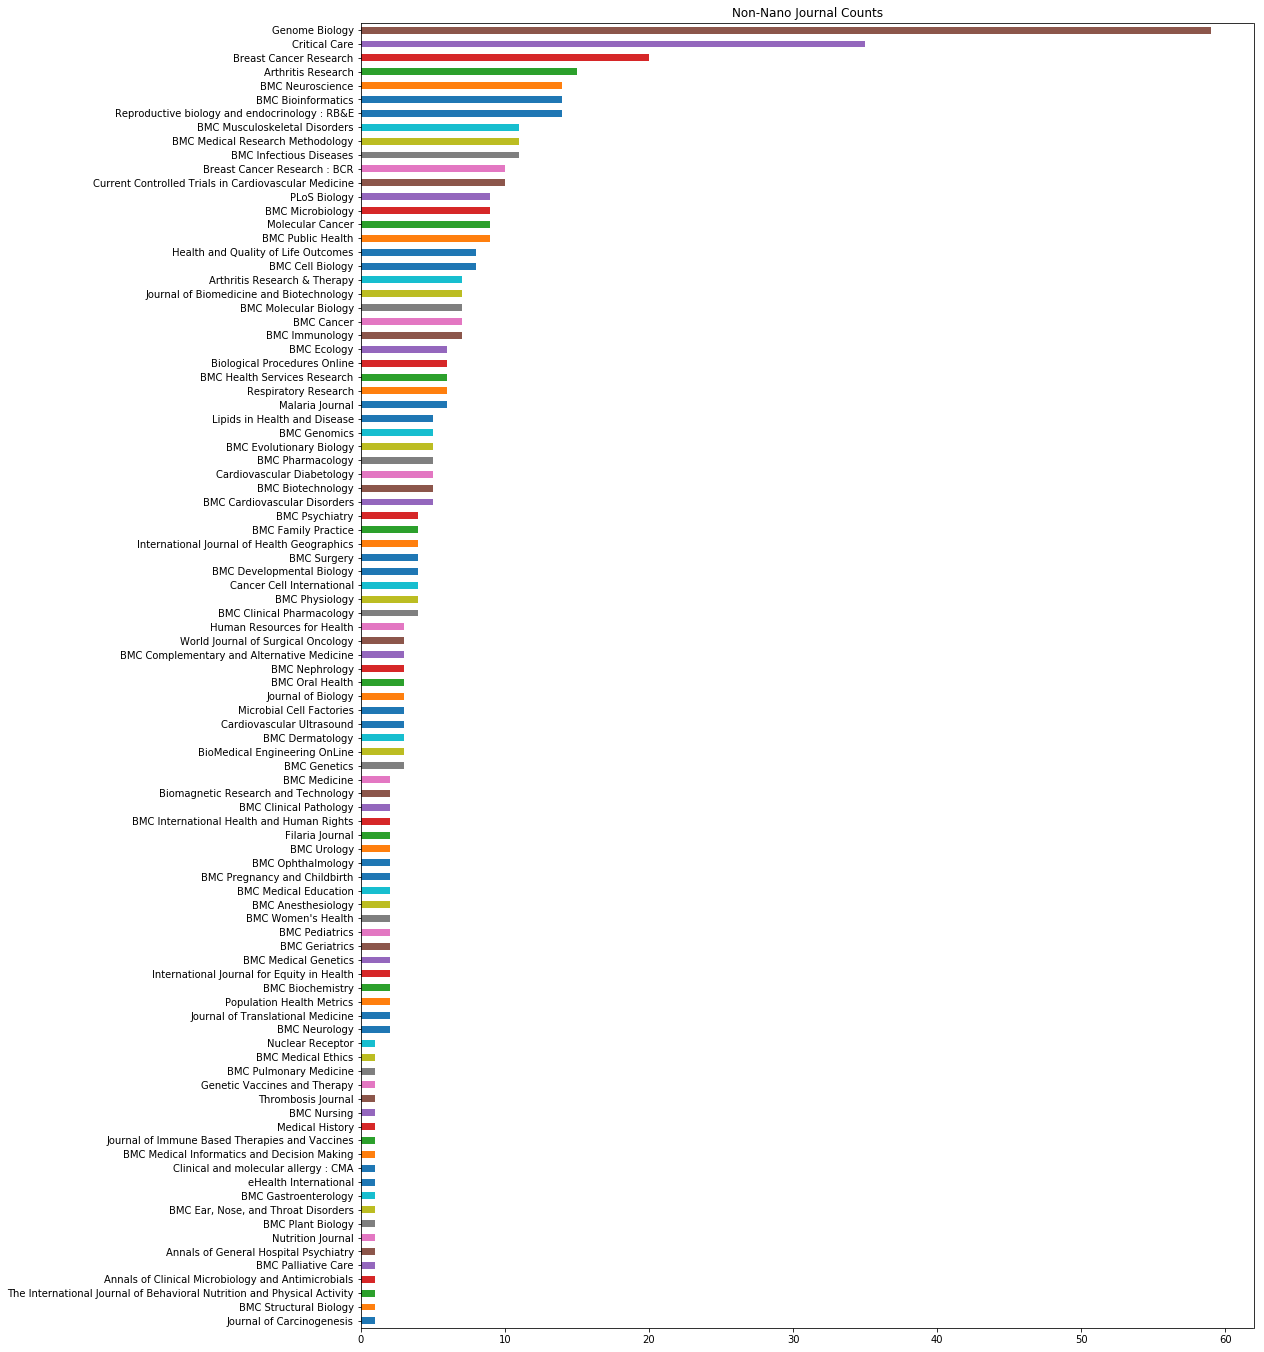

In [9]:
non_nano['journal'].value_counts(ascending=True).plot(kind="barh", figsize=(16,24), title="Non-Nano Journal Counts")

## What is the most prevalent words in each dataset?

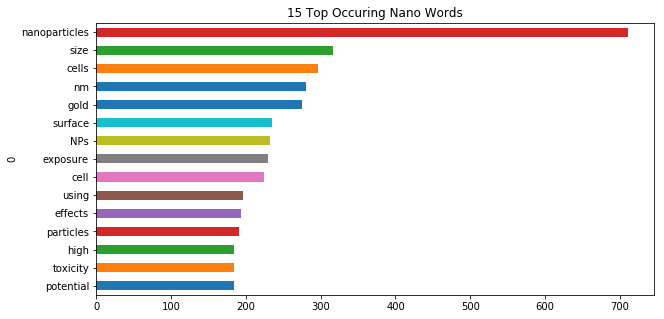

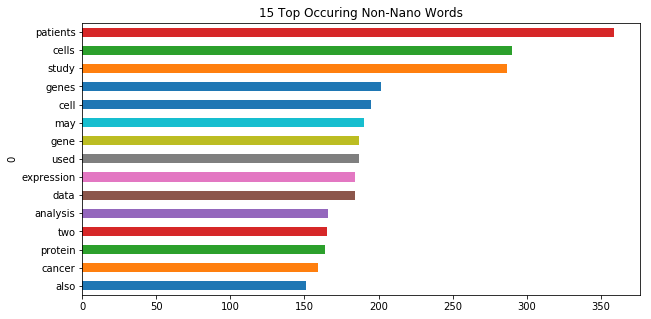

In [11]:
stop_words = set(stopwords.words('english') + list(string.punctuation))
nano_words = nltk.wordpunct_tokenize(" ".join(nano['abstract'].values))
non_nano_words = nltk.wordpunct_tokenize(" ".join(non_nano['abstract'].values))

nano_words_stopwords_removed = [w for w in nano_words if not w.lower() in stop_words and w.isalpha()]
non_nano_words_stopwords_removed = [w for w in non_nano_words if not w.lower() in stop_words and w.isalpha()]

nano_fdist = FreqDist(nano_words_stopwords_removed)
non_nano_fdist = FreqDist(non_nano_words_stopwords_removed)

nano_df = DataFrame(nano_fdist.most_common(15)).sort_values(1)
non_nano_df = DataFrame(non_nano_fdist.most_common(15)).sort_values(1)

nano_df.plot(kind='barh', x=0, y=1, figsize=(10,5), legend=False, title="15 Top Occuring Nano Words")
non_nano_df.plot(kind='barh', x=0, y=1, figsize=(10,5), legend=False, title="15 Top Occuring Non-Nano Words")

# Algorithim

## Split test and train set

In [43]:
max_features = 2000
tokenizer = Tokenizer(num_words=max_features, split=' ')
tokenizer.fit_on_texts(abstracts['abstract'].values)
X = tokenizer.texts_to_sequences(abstracts['abstract'].values)
X = pad_sequences(X, maxlen=500)
y = get_dummies(abstracts['is_nano']).values
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.4, random_state=42)
print("Number of Instances in Training Set:", len(X_train))
print("Number of Instances in Testing Set:", len(X_test))


Number of Instances in Training Set: 595
Number of Instances in Testing Set: 398


## LSTM Creation

In [22]:
embed_dim = 128
lstm_out = 196

model = Sequential()
model.add(Embedding(max_features, embed_dim, input_length=X.shape[1]))
model.add(LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(2, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

## LSTM Training

In [23]:
model.fit(X_train, Y_train, epochs=10, batch_size=32, verbose=2)

Epoch 1/10
 - 19s - loss: 0.6871 - acc: 0.5613
Epoch 2/10
 - 19s - loss: 0.4833 - acc: 0.8857
Epoch 3/10
 - 20s - loss: 0.1699 - acc: 0.9697
Epoch 4/10
 - 20s - loss: 0.0894 - acc: 0.9832
Epoch 5/10
 - 19s - loss: 0.1223 - acc: 0.9782
Epoch 6/10
 - 17s - loss: 0.0736 - acc: 0.9882
Epoch 7/10
 - 19s - loss: 0.0189 - acc: 0.9933
Epoch 8/10
 - 18s - loss: 0.0211 - acc: 1.0000
Epoch 9/10
 - 18s - loss: 0.0063 - acc: 1.0000
Epoch 10/10
 - 17s - loss: 0.0068 - acc: 0.9966


## LSTM Evaluation

Accuracy: 0.9296482412060302
Precision: 0.9635416666666666
Recall: 0.8980582524271845
F1: 0.9296482412060302


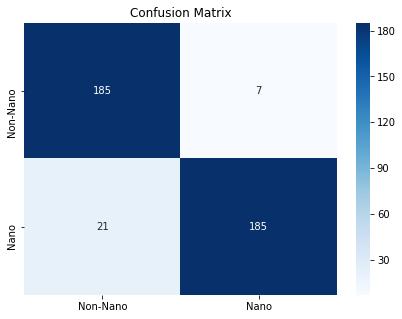

In [44]:
def get_metrics(y_pred, y_true):

    metrics = {}
    metrics['accuracy'] = accuracy_score(y_pred, y_true)
    metrics['precision'] = precision_score(y_pred, y_true)
    metrics['recall'] = recall_score(y_pred, y_true)
    metrics['f1'] = f1_score(y_pred, y_true)
    metrics['confusionmatrix'] = confusion_matrix(y_pred, y_true)
    return metrics

y_pred = model.predict(X_test, verbose=0, batch_size=32)
y_pred = [np.around(pred).astype('int') for pred in y_pred]   # Round the output of the softmax layer
y_pred = [np.argmax(x) for x in y_pred]    # Place back into distict predictions
Y_test = [np.argmax(x) for x in Y_test]    # Place back into distict predictions
metrics = get_metrics(y_pred, Y_test)
print("Accuracy:", metrics['accuracy'])
print("Precision:", metrics['precision'])
print("Recall:", metrics['recall'])
print("F1:", metrics['f1'])
df_cm = DataFrame(metrics['confusionmatrix'], index = ["Non-Nano", "Nano"],
                  columns = ["Non-Nano", "Nano"])
plt.figure(figsize = (7,5))
ax = plt.axes()
sn.heatmap(df_cm, annot=True,cmap='Blues', fmt='g')
ax.set_title('Confusion Matrix')
plt.show()

## Validation Sanity Check

In [60]:
val_data = read_json("../Data/JSON/Non-Nano.json")
val_data = val_data.sample(500)
X_val = tokenizer.texts_to_sequences(val_data['abstract'].values)
X_val = pad_sequences(X_val, maxlen=500)
val_pred = model.predict(X_val, verbose=0, batch_size=32)
val_pred = [np.around(pred).astype('int') for pred in val_pred]
val_pred = [np.argmax(x) for x in val_pred] 
val_true = np.zeros(500)

print("Accuracy", accuracy_score(val_pred, val_true)) 

Accuracy 0.916
